In [1]:
%reset -f
testID = 0

In [2]:
import os
import shutil

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics

%matplotlib inline

Using TensorFlow backend.


In [9]:
class Test:
    resultsRootDir = 'results'
    testID = None
    eegDataRaw = None
    eegHeader = None
    dataFileName = None
    model = None
    trainTestMap = None
    cmdHistory = ''
    cmdCount = 0
    
    def __init__(self, testID, filename):
        self.testID = str(testID).zfill(5)
        self.__createTestResultsDir()
        self.dataFileName = filename
        self.ResetState()
        
    def ResetState(self, filename=None):
        tmpFileName = ''
        cmdHistory = ''
        cmdCount = 0
        
        if filename is None:
            tmpFileName = self.dataFileName
        else:
            tmpFileName = filename
            
        self.__loadData(tmpFileName)
    
    def GetFeatureNames(self):
        return self.eegHeader[:-1]
    
    def GetCmdHistory(self):
        return self.cmdHistory
    
    def RemoveFeature(self, index):
        featureCount = len(self.eegHeader) - 1
        if index >= 0 and index < featureCount:
            self.__addToHistory('RemoveFeature_Idx:' + str(index) + '_' + self.eegHeader[index])
            self.eegHeader = np.delete(self.eegHeader, index)
            self.eegDataRaw = np.delete(self.eegDataRaw, index, axis=1)
                
    def PlotFeatures(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotFeatures_filePrefix:' + str(filePrefix))
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        featureCount = len(self.eegHeader) - 1
        idxSubplot = 0
        
        for itr in range(featureCount):
            idxSubplot = idxSubplot + 1
            currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
            currAx.grid()
            currAx.plot(self.eegDataRaw[:, itr])
            currAx.set_title(self.eegHeader[itr])
        
        idxSubplot = idxSubplot + 1
        currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
        currAx.grid()
        currAx.plot(self.eegDataRaw[:, -1])
        currAx.set_title(self.eegHeader[-1])

        if filePrefix is None:
            plt.show()
        else:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotBoxPlots(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotBoxPlots_filePrefix:' + str(filePrefix))
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.set_title('Feature range: Full')
        ax1.boxplot(self.eegDataRaw[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis='range'
                    , labels=self.eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=True)
        
        ax2 = fig.add_subplot(2, 1, 2)
        ax2.set_title('Feature range: [5%, 95%]')
        ax2.boxplot(self.eegDataRaw[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis=[5, 95]
                    , labels=self.eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=False)
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotMeanDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotMeanDistribution_filePrefix:' + str(filePrefix))
        idxEyeClosed = np.where(self.eegDataRaw[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.eegDataRaw[:, -1] == 0)[0]
        
        featureCount = len(self.eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Mean Distribution')
        ax.set_xticklabels(self.eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.eegDataRaw[idxEyeOpened][:, 0:featureCount].mean(axis=0), 'bo')
        ax.plot(xTick, self.eegDataRaw[idxEyeClosed][:, 0:featureCount].mean(axis=0), 'ro')
        ax.plot(xTick, self.eegDataRaw[:, 0:featureCount].mean(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)

    def PlotStdDevDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('PlotStdDevDistribution_filePrefix:' + str(filePrefix))
        idxEyeClosed = np.where(self.eegDataRaw[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.eegDataRaw[:, -1] == 0)[0]
        
        featureCount = len(self.eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Standard Deviation Distribution')
        ax.set_xticklabels(self.eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.eegDataRaw[idxEyeOpened][:, 0:featureCount].std(axis=0), 'bo')
        ax.plot(xTick, self.eegDataRaw[idxEyeClosed][:, 0:featureCount].std(axis=0), 'ro')
        ax.plot(xTick, self.eegDataRaw[:, 0:featureCount].std(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)

    def NormalizeData(self):
        self.__addToHistory('NormalizeData')
        scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
        self.eegDataRaw = scaler.fit_transform(self.eegDataRaw)
        
    def RemoveOutliers(self, upperLimit=None, lowerLimit=None):
        outLierIndexes = set()
        result = {}
        result['upper'] = set()
        result['lower'] = set()
        
        self.__addToHistory('RemoveOutliers_Upper:' + str(upperLimit)
                            + '_Lower:' + str(lowerLimit))
        featureCount = len(self.eegHeader) - 1

        if upperLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.eegDataRaw[:, itr] > upperLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['upper'].add(outLiers[i])

        if lowerLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.eegDataRaw[:, itr] < lowerLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['lower'].add(outLiers[i])
                        
        deleteIndexes = list(result['upper'].union(result['lower']))
        self.eegDataRaw = np.delete(self.eegDataRaw, deleteIndexes, axis=0)
        
        return result
    
    def FeatureCorrelationMatrix(self, filePrefix=None, figWidth=20, figHeight=20):
        self.__addToHistory('FeatureCorrelationMatrix_filePrefix:' + str(filePrefix))
        # Compute the correlation matrix
        corr = pd.DataFrame(data=self.eegDataRaw[:, :-1], columns=list(self.eegHeader[:-1])).corr()
        
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        # Set up the matplotlib figure
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title("Feature correlation matrix")
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(240, 10, as_cmap=True)
        
        # Draw the heatmap
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def CompileModel(self, lagCount, testSetPortion, neuronCount, modelArchitectureFilename,
                     lossFunc='mae', optimizerFunc='adam'):
        self.__addToHistory('CompileModel_Lag:' + str(lagCount)
                            + '_TestSize:' + str(testSetPortion)
                            + '_NeuronCount:' + str(neuronCount)
                            + '_LossFunc:' + str(lossFunc)
                            + '_OptimizerFunc:' + str(optimizerFunc))
        
        supervisedDataset = self.__timeSeriesToSupervised(lagCount)
        print '\n\n-----------------------------------------'
        print supervisedDataset
        print '-----------------------------------------\n\n'
        
        featureCount = len(self.eegHeader) - 1
        
        splitPoint = int(testSetPortion * supervisedDataset.shape[0])
        values = supervisedDataset.values
        trainingSet = values[:splitPoint, :]
        testingSet = values[splitPoint:, :]
        
        self.trainTestMap = {}

        self.trainTestMap['trainingSet_inFeatures'] = trainingSet[:, :-1]
        self.trainTestMap['trainingSet_outFeature'] = trainingSet[:, -1]
        
        self.trainTestMap['testingSet_inFeatures'] = testingSet[:, :-1]
        self.trainTestMap['testingSet_outFeature'] = testingSet[:, -1]
        
        # reshape input to be 3D [samples, timesteps, features]
        featureDimSize = (((featureCount + 1) * lagCount) + featureCount) / lagCount
        
        self.trainTestMap['trainingSet_inFeatures_reShaped'] =self.trainTestMap['trainingSet_inFeatures'].reshape(
            (self.trainTestMap['trainingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
        self.trainTestMap['testingSet_inFeatures_reShaped'] = self.trainTestMap['testingSet_inFeatures'].reshape(
            (self.trainTestMap['testingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
        # design network
        self.model = Sequential()
        
        self.model.add(
            LSTM(neuronCount,
                 input_shape=(
                     self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[1],
                     self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[2])
                )
        )
        
        self.model.add(Dense(1))
        self.model.compile(loss=lossFunc, optimizer=optimizerFunc)
        
        # Visualize LSTM network
        pathToFile = self.resultsRootDir + "/" + self.testID + "/" + modelArchitectureFilename
        plot_model(self.model, to_file=pathToFile, show_shapes=True)
        
    def FitModel(self, epochCount, batchSize, lossFuncFilePrefix=None,
                 predictionFilePrefix=None, figWidth=20, figHeight=20):
        assert self.model != None, 'Model not compiled'
        
        self.__addToHistory('FitModel_EpochCount:' + str(epochCount)
                            + '_BatchSize:' + str(batchSize)
                            + '_lossFuncFilePrefix:' + str(lossFuncFilePrefix)
                            + '_predictionFilePrefix:' + str(predictionFilePrefix))
        
        print self.trainTestMap['trainingSet_inFeatures_reShaped'].shape
        print self.trainTestMap['trainingSet_outFeature'].shape
        
        # Fit model
        history = self.model.fit(self.trainTestMap['trainingSet_inFeatures_reShaped'],
                                 self.trainTestMap['trainingSet_outFeature'],
                                 epochs=epochCount,
                                 batch_size=batchSize,
                                 validation_data=(
                                     self.trainTestMap['testingSet_inFeatures_reShaped'],
                                     self.trainTestMap['testingSet_outFeature']
                                 ),
                                 verbose=2, shuffle=False)
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Loss Function')
        ax.plot(history.history['loss'], label='train')
        ax.plot(history.history['val_loss'], label='test')
                    
        if lossFuncFilePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + lossFuncFilePrefix
            plt.savefig(pathToFile)

        testDataPrediction = self.model.predict(self.trainTestMap['trainingSet_inFeatures_reShaped'])
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
#         plt.plot(testDataPrediction)
        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Prediction')
        ax.plot(testDataPrediction)

        if predictionFilePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + predictionFilePrefix
            plt.savefig(pathToFile)

        # Reset model
        self.model = None
        self.trainTestMap = None
    
    def __createTestResultsDir(self):
        dirName = "%s/%s" % (self.resultsRootDir, self.testID)
        if os.path.exists(dirName):
            shutil.rmtree(dirName)
        os.makedirs(dirName)
        
    def __loadData(self, filename):
        self.eegDataRaw = np.genfromtxt(filename, delimiter=',', skip_header=1)
        self.eegHeader = np.genfromtxt(filename, delimiter=',', max_rows=1, dtype=str)

    def __timeSeriesToSupervised(self, lagCount):
        featureCount = len(self.eegHeader) - 1

        dfInput = pd.DataFrame(self.eegDataRaw[:, :-1])
        dfOutput = pd.DataFrame(self.eegDataRaw[:, -1])
        
        cols, names = list(), list()

        for i in range(lagCount, 0, -1):
            cols.append(dfInput.shift(i))
            cols.append(dfOutput.shift(i))
            names += [('%s(t-%d)' % (self.eegHeader[j], i)) for j in range(featureCount)]
            names += [('%s(t-%d)' % (self.eegHeader[-1], i))]

        cols.append(dfInput)
        cols.append(dfOutput)
        names += [('%s(t)' % self.eegHeader[j]) for j in range(featureCount)]
        names += [('%s(t)' % self.eegHeader[-1])]

        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # Drop rows containing NaN values
        agg.dropna(inplace=True)
        return agg
    
    def __addToHistory(self, newCmd):
        tmpStr = ''
        if self.cmdCount > 0:
            tmpStr += '\n'
            for itr in range(self.cmdCount):
                tmpStr += '+'
                
        tmpStr += newCmd
        self.cmdHistory += tmpStr
        self.cmdCount += 1

TestID:  6


-----------------------------------------
       AF3(t-1)   F7(t-1)   F3(t-1)  FC5(t-1)   T7(t-1)   P7(t-1)   O1(t-1)  \
1      0.010702  0.236931  0.556326  0.002648  0.515557  0.005053  0.003558   
2      0.010687  0.236004  0.557117  0.002649  0.513684  0.005054  0.003559   
3      0.010697  0.236416  0.557379  0.002661  0.512514  0.005046  0.003558   
4      0.010701  0.237446  0.557556  0.002660  0.514035  0.005043  0.003559   
5      0.010692  0.237446  0.556854  0.002653  0.514971  0.005054  0.003556   
6      0.010676  0.236004  0.555448  0.002656  0.514503  0.005056  0.003552   
7      0.010671  0.235283  0.554833  0.002653  0.514035  0.005048  0.003546   
8      0.010691  0.236416  0.554482  0.002640  0.514152  0.005044  0.003541   
9      0.010692  0.237241  0.554131  0.002634  0.514387  0.005047  0.003548   
10     0.010692  0.237343  0.554219  0.002638  0.514152  0.005043  0.003551   
11     0.010692  0.237241  0.553517  0.002640  0.513801  0.005034  0.003542 

(2995, 1, 29)
(2995,)
Train on 2995 samples, validate on 11984 samples
Epoch 1/50
 - 1s - loss: 0.4802 - val_loss: 0.3977
Epoch 2/50
 - 0s - loss: 0.4143 - val_loss: 0.3302
Epoch 3/50
 - 0s - loss: 0.3316 - val_loss: 0.2281
Epoch 4/50
 - 0s - loss: 0.2098 - val_loss: 0.0803
Epoch 5/50
 - 0s - loss: 0.0586 - val_loss: 0.0125
Epoch 6/50
 - 0s - loss: 0.0284 - val_loss: 0.0303
Epoch 7/50
 - 0s - loss: 0.0327 - val_loss: 0.0236
Epoch 8/50
 - 0s - loss: 0.0105 - val_loss: 0.0261
Epoch 9/50
 - 0s - loss: 0.0248 - val_loss: 0.0133
Epoch 10/50
 - 0s - loss: 0.0202 - val_loss: 0.0247
Epoch 11/50
 - 0s - loss: 0.0237 - val_loss: 0.0360
Epoch 12/50
 - 0s - loss: 0.0233 - val_loss: 0.0162
Epoch 13/50
 - 0s - loss: 0.0214 - val_loss: 0.0184
Epoch 14/50
 - 0s - loss: 0.0199 - val_loss: 0.0379
Epoch 15/50
 - 0s - loss: 0.0277 - val_loss: 0.0073
Epoch 16/50
 - 0s - loss: 0.0136 - val_loss: 0.0149
Epoch 17/50
 - 0s - loss: 0.0250 - val_loss: 0.0163
Epoch 18/50
 - 0s - loss: 0.0285 - val_loss: 0.0179
Ep

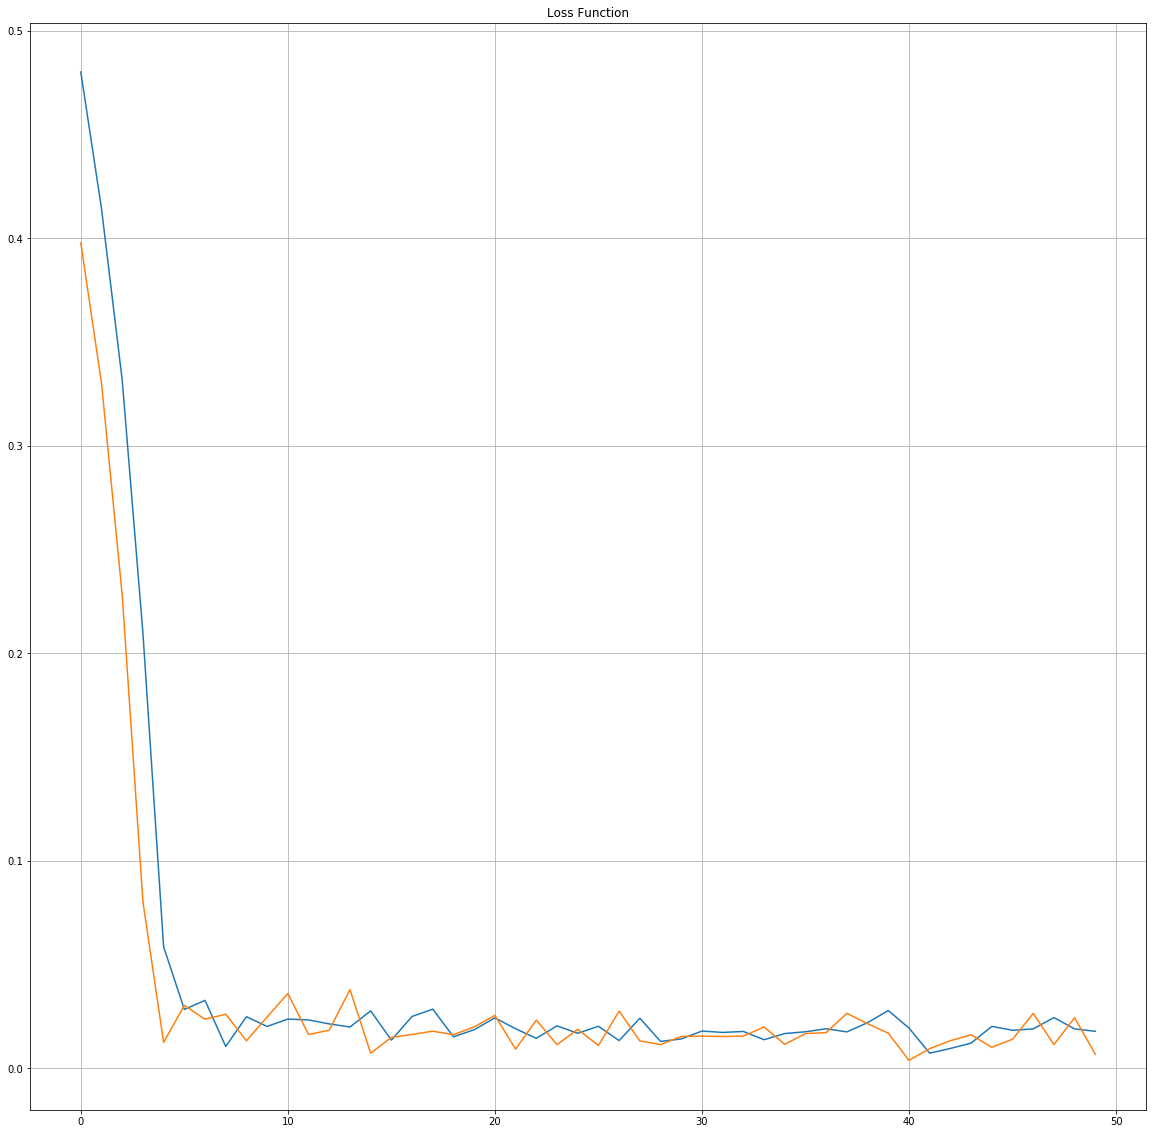

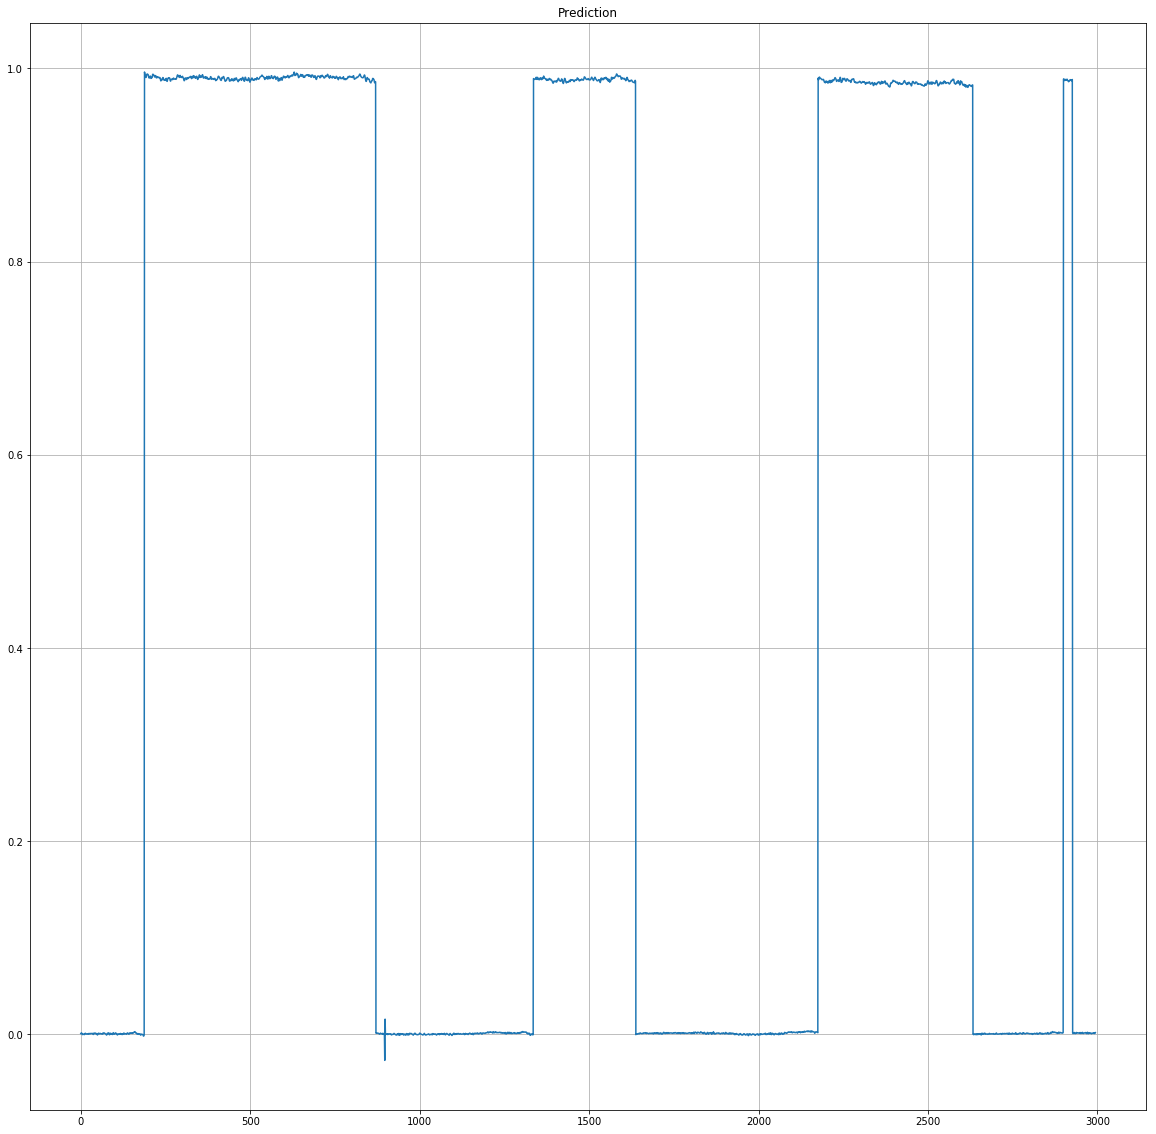

In [12]:
testID += 1

print "TestID: ", testID
a = Test(testID, 'EEGEyeState.arff.csv')

a.NormalizeData()

lagValue = 1


a.CompileModel(lagValue, 0.2, 50, 'modelArchitecture')
a.FitModel(50, 72,
           lossFuncFilePrefix='lossFile',
           predictionFilePrefix='predictionFile')


print '\n\n-----------------------\n' + a.GetCmdHistory()


TestID:  46
(7489, 2, 22)
(7489,)
Train on 7489 samples, validate on 7489 samples
Epoch 1/100
 - 2s - loss: 0.9774 - val_loss: 0.4026
Epoch 2/100
 - 0s - loss: 0.5358 - val_loss: 0.3941
Epoch 3/100
 - 0s - loss: 0.5289 - val_loss: 0.4099
Epoch 4/100
 - 0s - loss: 0.5249 - val_loss: 0.4259
Epoch 5/100
 - 0s - loss: 0.5209 - val_loss: 0.4419
Epoch 6/100
 - 0s - loss: 0.5169 - val_loss: 0.4580
Epoch 7/100
 - 0s - loss: 0.5128 - val_loss: 0.4742
Epoch 8/100
 - 0s - loss: 0.5087 - val_loss: 0.4904
Epoch 9/100
 - 0s - loss: 0.5046 - val_loss: 0.5066
Epoch 10/100
 - 0s - loss: 0.5005 - val_loss: 0.5229
Epoch 11/100
 - 0s - loss: 0.4964 - val_loss: 0.5391
Epoch 12/100
 - 0s - loss: 0.4923 - val_loss: 0.5554
Epoch 13/100
 - 0s - loss: 0.4882 - val_loss: 0.5717
Epoch 14/100
 - 0s - loss: 0.4841 - val_loss: 0.5880
Epoch 15/100
 - 0s - loss: 0.4800 - val_loss: 0.6043
Epoch 16/100
 - 0s - loss: 0.4759 - val_loss: 0.6206
Epoch 17/100
 - 0s - loss: 0.4718 - val_loss: 0.6380
Epoch 18/100
 - 0s - loss:

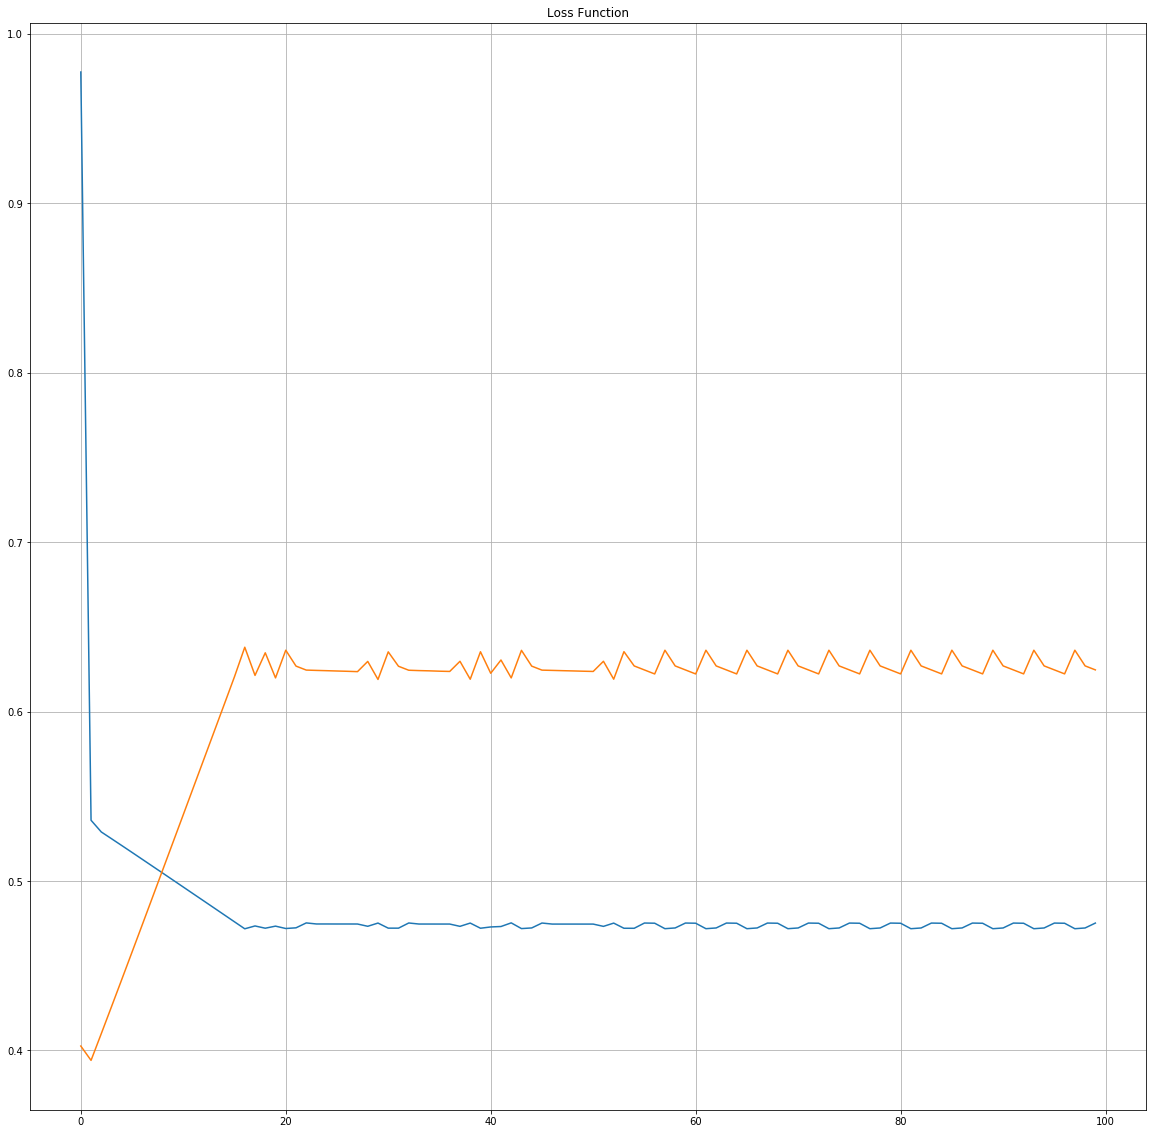

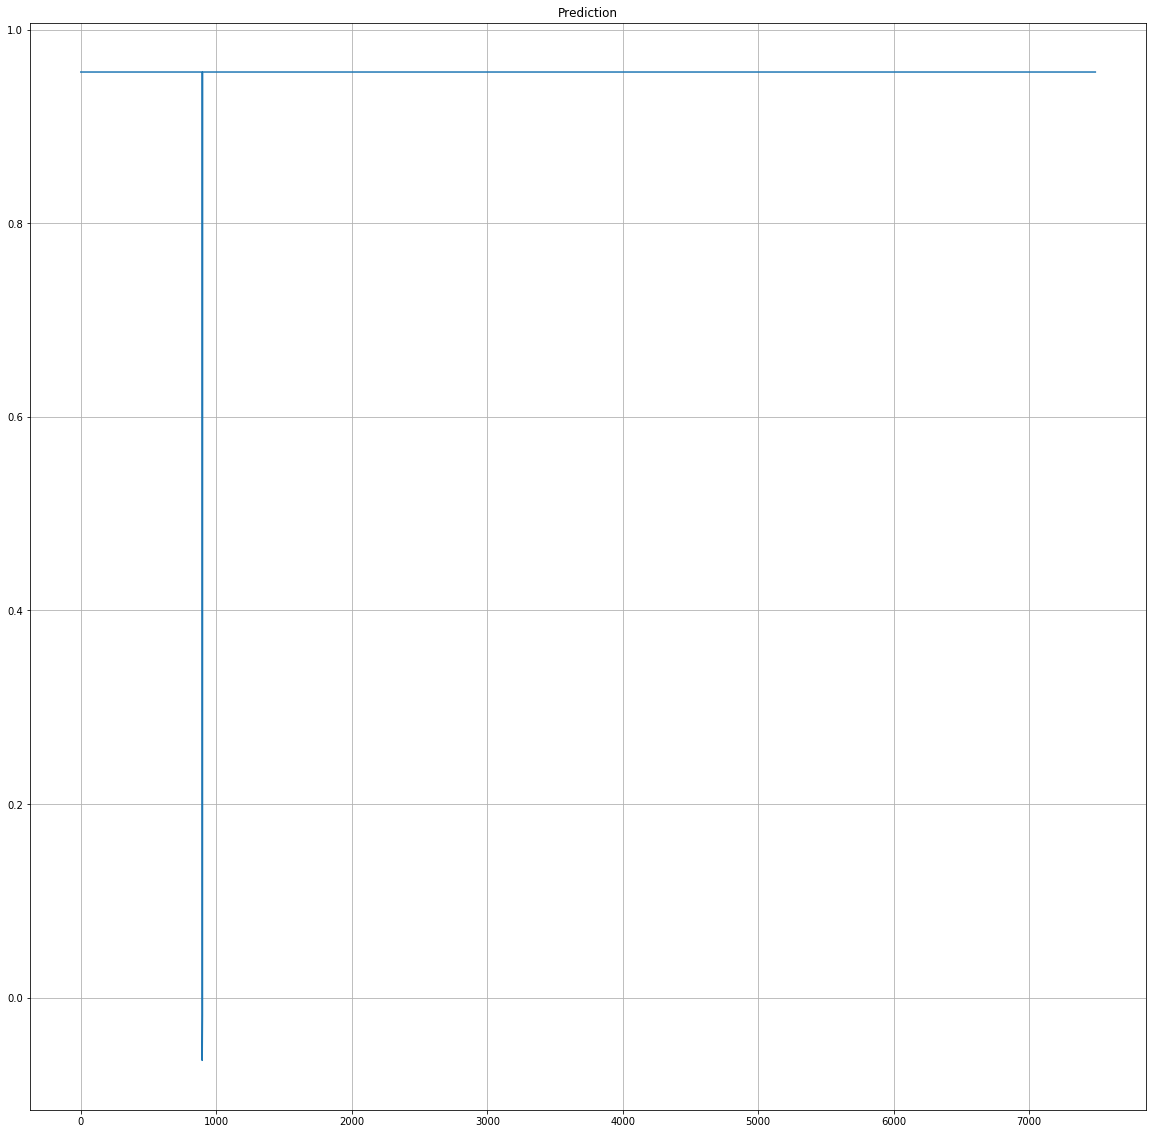

In [126]:
testID += 1

print "TestID: ", testID
a = Test(testID, 'EEGEyeState.arff.csv')


lagValue = 2

a.CompileModel(lagValue, 0.5, 50, 'modelArchitecture')
a.FitModel(100, 100, 'lossFunc')





# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # # result = a.GetFeatureNames()
# # # print result

# a.PlotFeatures(filePrefix='01_RawData')
# a.FeatureCorrelationMatrix(filePrefix='02_CorrelationMatrix_RawData')
# a.PlotBoxPlots(filePrefix='03_BoxPlot_RawData')
# a.PlotMeanDistribution('04_MeanDistribution_RawData')
# a.PlotStdDevDistribution('05_StdDevDistribution_RawData')

# res = a.RemoveOutliers(upperLimit=5000)
# a.PlotFeatures(filePrefix='06_RemovedOutliers')
# a.FeatureCorrelationMatrix(filePrefix='07_CorrelationMatrix_OutliersRemoved')
# a.PlotBoxPlots(filePrefix='08_BoxPlot_OutliersRemove')
# a.PlotMeanDistribution('09_MeanDistribution_OutliersRemove')
# a.PlotStdDevDistribution('10_StdDevDistribution_OutliersRemove')

# a.NormalizeData()
# a.PlotFeatures(filePrefix='11_NormalizedData')
# a.FeatureCorrelationMatrix(filePrefix='12_CorrelationMatrix_NormalizedData')
# a.PlotBoxPlots(filePrefix='13_BoxPlot_NormalizedData')
# a.PlotMeanDistribution('14_MeanDistribution_NormalizedData')
# a.PlotStdDevDistribution('15_StdDevDistribution_NormalizedData')

print a.GetCmdHistory()


In [281]:
aaa = np.full(5, True, dtype=bool)
aaa[2] = aaa[4] = False
print aaa
res = np.where(aaa == True)
print res
print len(res[0])

[ True  True False  True False]
(array([0, 1, 3]),)
3


In [402]:
x = {}
x['aaa'] = set()
x['aaa'].add(1)
x['aaa'].add(2)
x['aaa'].add(3)

x['bbb'] = set()
# x['bbb'].add(1)
# x['bbb'].add(200)
# x['bbb'].add(3)


res = x['bbb'].union(x['aaa'])
print res


set([1, 2, 3])


In [9]:
cmd = str('')
cmd += 'aa'

print cmd

aa
